In [98]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
'''
Input: 
    2 coordinates of line segment
Output: 
    Hough parameters theta and rho, and length of line
    theta is the slope angle of normal line of line
    rho is the distance to origin with sign depending on sign of x intersect 
    range of theta is within -pi/2 to pi/2
    range of rho is within -maxRho to maxRho, where maxRho is the length of diagnoal line of image
    To distinguish 2 line segments with same distance to origin and slope but in different sides of origin,
    we define that for line with negative x intersect, rho is negative with abs equal to distance to origin. 
'''
def computeHoughTransformCoord(x1, y1, x2, y2):

    if y1 == y2:
        theta = np.pi/2
        rho = abs(y1)
        length = abs(x1 - x2)
        return theta, rho, length

    k_inv =  (x1 - x2) / (y1 - y2)
    theta = np.arctan(-k_inv)

    A = y2 - y1
    B = x2 - x1
    C = abs(x2*y1 - x1*y2)
    length = np.sqrt(A**2 + B**2)
    rho = C / length

    # distinguish same distance and theta but different sides
    X0 = - k_inv * y1 + x1
    if X0 < 0:
        rho = -rho
    
    return theta, rho, length

'''
compute average gray scale around a line
'''
def average_grayscale_along_line(image, x1, y1, x2, y2):
    # Calculate the length of the line
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Calculate the unit direction vector
    vx = (x2 - x1) / L
    vy = (y2 - y1) / L
    
    # Initialize a list to store average grayscale values
    grayscale_values = []
    
    # Iterate over each point along the line
    for i in range(int(L)):
        x = int(x1 + i * vx)
        y = int(y1 + i * vy)
        
        # Iterate over 5 points to the left and 5 points to the right of the current point
        for j in range(-9, 10):
            x_neighbor = x + j
            if x_neighbor >= 0 and x_neighbor < image.shape[1]\
                and y >= 0 and y < image.shape[0]:
                grayscale_value = image[y, x_neighbor]
                grayscale_values.append(grayscale_value)
        
    average_grayscale = np.mean(grayscale_values)
    
    return average_grayscale


'''
Input:
    grid: a list contains (theta, rho, line, d) tuple
    color: the color of runway
    draw: whether to draw result
Output:
    (theta, rho): Hough parameters
'''
def computeResult(grid: list, lineImg, color = (0, 0, 255), draw=False):
    # 假设 max_index 是一个包含多个元组 (theta, rho) 的列表
    thetas = [pair[0] for pair in grid]
    rhos = [pair[1] for pair in grid]
    lines = [pair[2] for pair in grid]
    ds = [pair[3] for pair in grid]

    # thetas = np.asarray(thetas)
    # rhos = np.asarray(rhos)
    # ds = np.asarray(ds)

    # theta = np.sum(thetas * ds)/np.sum(ds)
    # rho = np.sum(rhos * ds)/np.sum(ds)

    # m = 1/np.tan(-theta)
    # c = rho / np.sin(theta)

    x = []
    y = []
    weights = []
    for line, d in zip(lines, ds):
        line = line[0]
        x.append(line[0])
        x.append(line[2])
        y.append(line[1])
        y.append(line[3])
        weights.append(d)
        weights.append(d)

    A = np.vstack([x, np.ones(len(x))]).T
    w = np.diag(np.sqrt(weights))
    m, c = np.linalg.lstsq(w @ A, y @ w, rcond=None)[0]

    if(m == 0):
        theta = np.pi/2
        rho = c
    else:
        theta = np.arctan(-1/m)
        rho = c * np.sin(theta)

    if draw == True:
        # draw result lines
        if theta == 0:
            cv2.line(lineImg, (rho, -1000), (rho, 1000), color, 1)
        elif not np.isnan(theta):
            LL = 3000
            cv2.line(lineImg, (0, int(c)), (LL, int( LL *m + c)), color, 1)

        # draw grid lines    
        for line, d in zip(lines, ds):
            x1, y1, x2, y2 = map(int, line[0])
            cv2.line(lineImg, (x1, y1), (x2, y2), (255, 0, 255), 1)

    return theta, rho

def draw_lines(img, lines, gray_thres):
    drawn_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for line in lines:
        x1, y1, x2, y2 = map(int, line[0])
        average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
        if average_grayscale < gray_thres:
            cv2.line(drawn_img, (x1, y1), (x2, y2), (255, 0, 0), 1, cv2.LINE_AA)
        else:
            cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
    # plt.show()

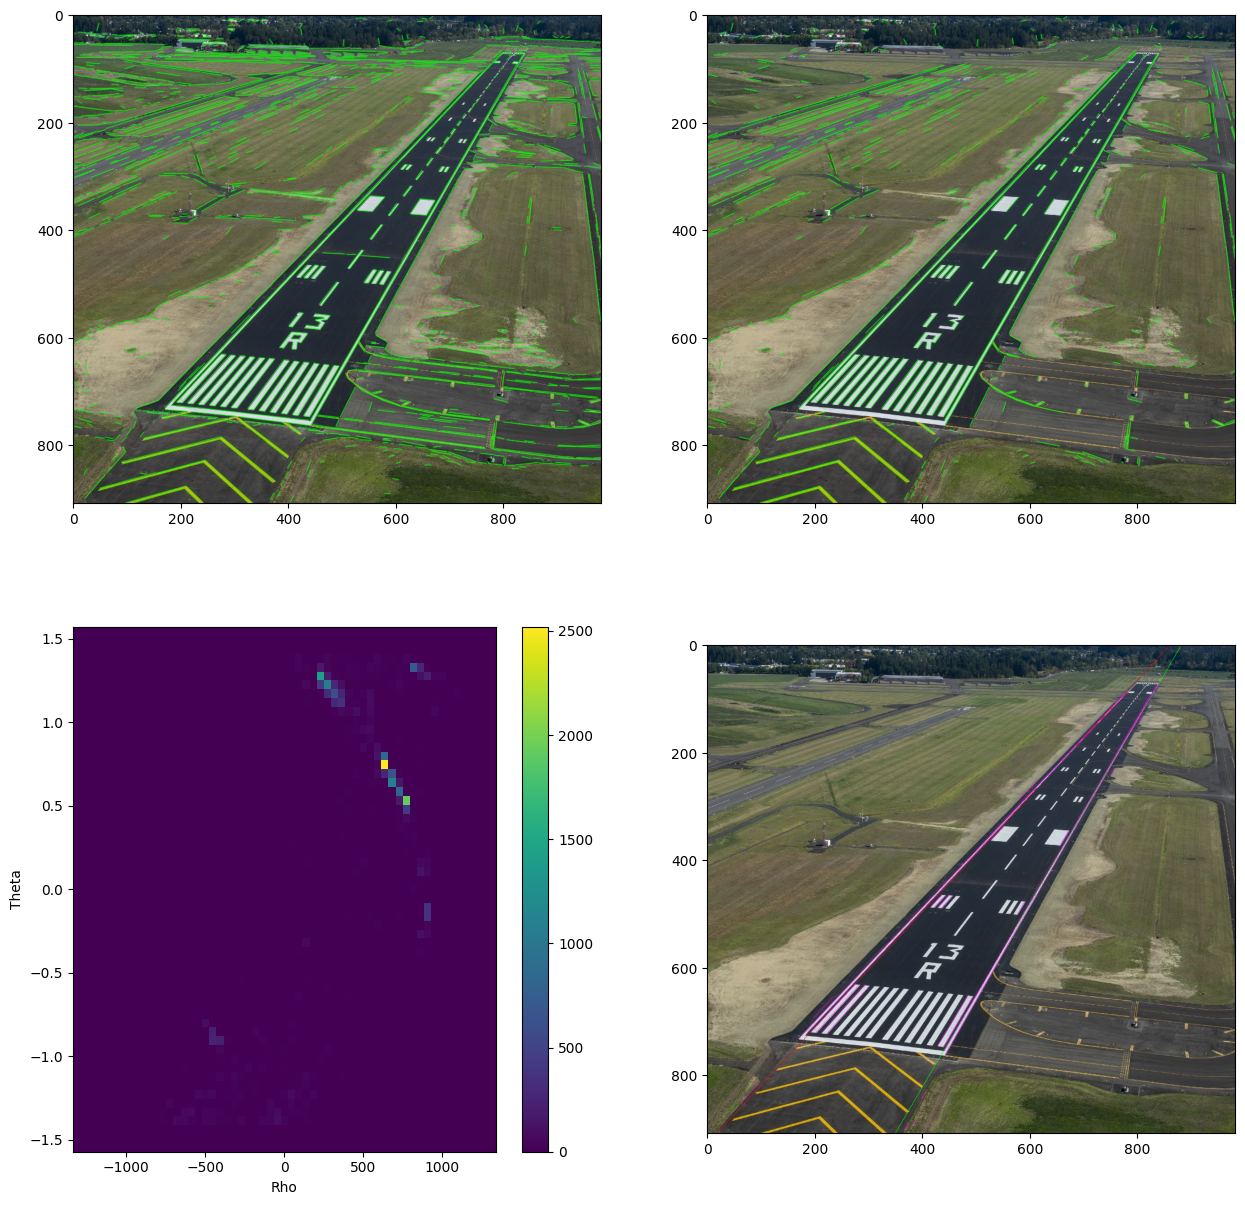

In [100]:
img = cv2.imread("images/2.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

height, width, _ = img.shape
lsd = cv2.createLineSegmentDetector(scale=0.8, sigma_scale=0.6, quant=2.0, ang_th=22.5, log_eps=0.0, density_th=0.7, n_bins=1024)
lines, _, prec, nfa = lsd.detect(gray)

length_thres = 2
gray_thres = 0

plt.figure(figsize=[15,15])

# show original lines
plt.subplot(2,2,1)
draw_lines(img, lines, gray_thres)

thetaList = []
dList = []
rhoList = []
lineList = []
for line in lines:
    # check average gray scale
    x1, y1, x2, y2 = map(int, line[0])
    average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
    if average_grayscale < gray_thres:
        continue
    
    # check short lines and horizontal lines
    theta, rho, d = computeHoughTransformCoord(x1, y1, x2, y2)
    if d < length_thres:
        continue
    if abs(np.abs(theta) - np.pi/2) < np.pi / 16 or np.abs(theta) > 1.5707963:
        continue

    thetaList.append(theta)
    dList.append(d)
    rhoList.append(rho)
    lineList.append(line)

# show filtered lines
plt.subplot(2,2,2)
draw_lines(img, lineList, gray_thres)


if width * height < 100000:
    N = 40
else:
    N = 60

Ntheta = N
Nrho = N
maxRho = np.sqrt(img.shape[0]**2 + img.shape[1]**2)
# 创建一个网格
theta_bins = np.linspace(-np.pi/2, np.pi/2, num=Ntheta)
rho_bins = np.linspace(-maxRho, maxRho, num=Nrho)
totalLengthGrid = np.zeros((len(theta_bins) - 1, len(rho_bins) - 1))
thetaRhoGrid = [[[] for _ in range(len(rho_bins) - 1)] for _ in range(len(theta_bins) - 1)]

# 映射thetaList和rhoList到网格中
for theta, rho, d, line in zip(thetaList, rhoList, dList, lineList):
    theta_idx = np.digitize(theta, theta_bins) - 1
    rho_idx = np.digitize(rho, rho_bins) - 1
    # print(theta, rho, theta_idx, rho_idx)
    totalLengthGrid[theta_idx, rho_idx] += d
    thetaRhoGrid[theta_idx][rho_idx].append((theta, rho, line, d))

# 绘制热力图
plt.subplot(2,2,3)
plt.imshow(totalLengthGrid, extent=(rho_bins[0], rho_bins[-1], theta_bins[0], theta_bins[-1]), aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel('Rho')
plt.ylabel('Theta')
# plt.show()

# 找到最大元素的索引
max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
max_d = totalLengthGrid[max_index]

# 将最大元素设为负无穷
totalLengthGrid[max_index] = -np.inf

# 找到第二大元素的索引
second_max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
second_max_d = totalLengthGrid[second_max_index]

totalLengthGrid[second_max_index] = -np.inf

third_max_index = np.unravel_index(np.argmax(totalLengthGrid), totalLengthGrid.shape)
third_max_d = totalLengthGrid[third_max_index]

lineImg = img.copy()
theta0, rho0 = computeResult(thetaRhoGrid[max_index[0]][max_index[1]], lineImg, color = (0, 0, 255), draw=True)
theta1, rho1 = computeResult(thetaRhoGrid[second_max_index[0]][second_max_index[1]], lineImg, color = (0, 255, 0), draw=True)
# computeResult(thetaRhoGrid[third_max_index[0]][third_max_index[1]], lineImg, color=(255, 0, 0), draw=True)

plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(lineImg, cv2.COLOR_BGR2RGB))
plt.show()
